# Blockchain para Gastos Governamentais
## Sistema Multi-Backend com Ancoragem entre Canais

### Demonstração Prática

---

Este notebook demonstra um sistema blockchain para rastreamento de gastos governamentais em três níveis:
- **União** (Governo Federal)
- **Estado** (Governo Estadual)
- **Região** (Governo Municipal)

Cada nível opera seu próprio backend com direitos administrativos em seu canal específico.

## 📋 Índice

1. [Arquitetura do Sistema](#1-arquitetura-do-sistema)
2. [Ancoragem entre Canais (Cross-Channel Anchoring)](#2-ancoragem-entre-canais)
3. [Configuração Inicial](#3-configuração-inicial)
4. [Health Check - Verificando os Backends](#4-health-check)
5. [Criação de Tipos de Documentos](#5-criação-de-tipos-de-documentos)
6. [Transferência União → Estado (COM Ancoragem)](#6-transferência-união-estado)
7. [Transferência Estado → União (COM Ancoragem - Fluxo Reverso)](#7-transferência-estado-união)
8. [Gastos Internos (SEM Ancoragem)](#8-gastos-internos)
9. [Comparação: Documentos Ancorados vs Não-Ancorados](#9-comparação)
10. [Consultas e Filtros](#10-consultas-e-filtros)

---

## 1. Arquitetura do Sistema

### Multi-Backend Architecture

O sistema utiliza três instâncias de backend, cada uma com privilégios administrativos em seu próprio canal:

![Screenshot 2025-11-30 193553.png](<attachment:Screenshot 2025-11-30 193553.png>)

### Características:

- ✅ **Cada backend pode ESCREVER apenas em seu próprio canal**
- ✅ **Todos os backends podem LER de todos os canais**
- ✅ **Ancoragem criptográfica entre canais para transferências**
- ✅ **Documentos internos não requerem ancoragem**
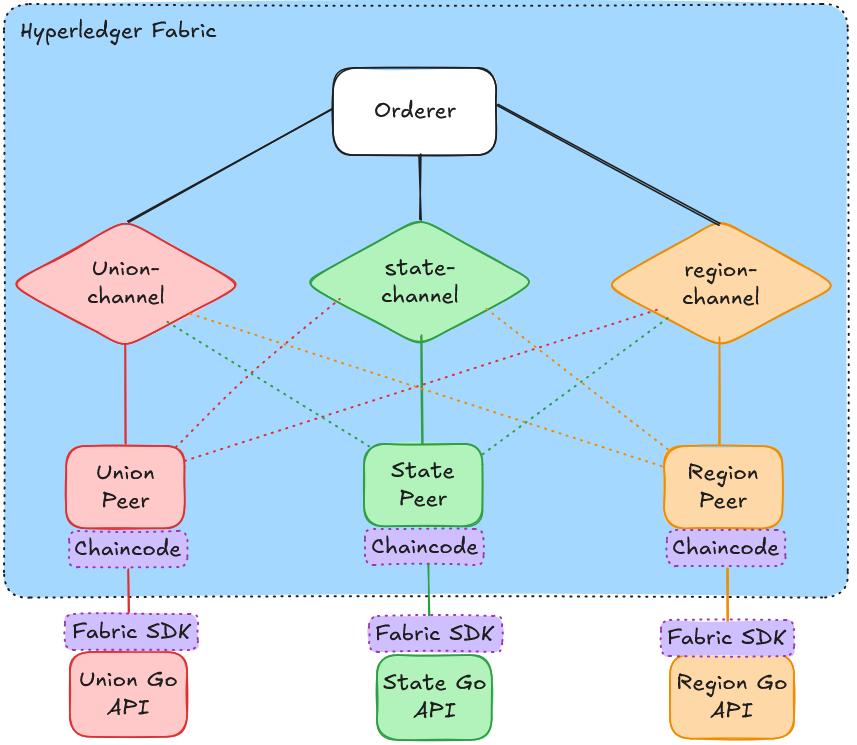

---

## 2. Ancoragem entre Canais

### O que é Cross-Channel Anchoring?

A ancoragem entre canais é um mecanismo que vincula documentos em diferentes canais blockchain usando **hashes criptográficos**.

### Como Funciona?

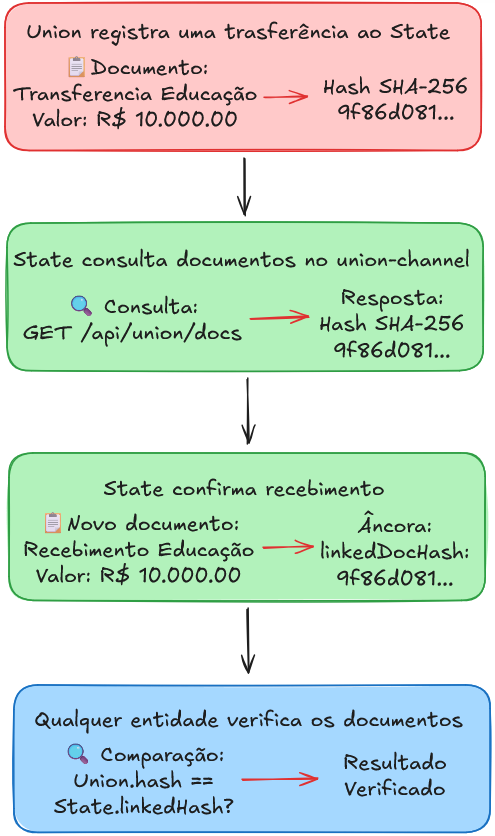

### Vantagens:

1. **Imutabilidade**: Links não podem ser alterados
2. **Verificabilidade**: Qualquer um pode verificar a autenticidade
3. **Transparência**: Rastreamento completo entre organizações
4. **Auditoria**: Trilha de auditoria criptograficamente segura

---

## 3. Configuração Inicial

Definindo as URLs dos backends e variáveis auxiliares:

In [ ]:
%%bash
# URLs dos backends
UNION_API="http://localhost:3000/api"
STATE_API="http://localhost:3001/api"
REGION_API="http://localhost:3002/api"

# Nomes dos canais
UNION_CHANNEL="union"
STATE_CHANNEL="state"
REGION_CHANNEL="region"

---

## 4. Health Check - Verificando os Backends

Vamos verificar se todas as instâncias de backend estão rodando e ver suas configurações:

In [1]:
%%bash
echo "🔍 Verificando Backend da União (porta 3000)..."
curl -s http://localhost:3000/health | jq '.'

🔍 Verificando Backend da União (porta 3000)...
{
  "service": "gov-spending-api",
  "status": "healthy"
}


In [2]:
%%bash
echo "📋 Configuração do Backend da União:"
curl -s http://localhost:3000/config | jq '.'

📋 Configuração do Backend da União:
{
  "allChannels": [
    "union",
    "state",
    "region"
  ],
  "channelDetails": {
    "region": {
      "channelName": "region-channel",
      "isAdmin": false,
      "userName": "User1"
    },
    "state": {
      "channelName": "state-channel",
      "isAdmin": false,
      "userName": "User1"
    },
    "union": {
      "channelName": "union-channel",
      "isAdmin": true,
      "userName": "Admin"
    }
  },
  "writableChannels": [
    "union"
  ]
}


In [3]:
%%bash
echo "🔍 Verificando Backend do Estado (porta 3001)..."
curl -s http://localhost:3001/health | jq '.'

🔍 Verificando Backend do Estado (porta 3001)...
{
  "service": "gov-spending-api",
  "status": "healthy"
}


In [4]:
%%bash
echo "📋 Configuração do Backend do Estado:"
curl -s http://localhost:3001/config | jq '.'

📋 Configuração do Backend do Estado:
{
  "allChannels": [
    "union",
    "state",
    "region"
  ],
  "channelDetails": {
    "region": {
      "channelName": "region-channel",
      "isAdmin": false,
      "userName": "User1"
    },
    "state": {
      "channelName": "state-channel",
      "isAdmin": true,
      "userName": "Admin"
    },
    "union": {
      "channelName": "union-channel",
      "isAdmin": false,
      "userName": "User1"
    }
  },
  "writableChannels": [
    "state"
  ]
}


In [5]:
%%bash
echo "🔍 Verificando Backend da Região (porta 3002)..."
curl -s http://localhost:3002/health | jq '.'

🔍 Verificando Backend da Região (porta 3002)...
{
  "service": "gov-spending-api",
  "status": "healthy"
}


In [6]:
%%bash
echo "📋 Configuração do Backend da Região:"
curl -s http://localhost:3002/config | jq '.'

📋 Configuração do Backend da Região:
{
  "allChannels": [
    "state",
    "region",
    "union"
  ],
  "channelDetails": {
    "region": {
      "channelName": "region-channel",
      "isAdmin": true,
      "userName": "Admin"
    },
    "state": {
      "channelName": "state-channel",
      "isAdmin": false,
      "userName": "User1"
    },
    "union": {
      "channelName": "union-channel",
      "isAdmin": false,
      "userName": "User1"
    }
  },
  "writableChannels": [
    "region"
  ]
}


### 💡 Observação

Note que cada backend tem:
- `writableChannels`: Lista os canais onde tem direito de escrita (apenas o seu próprio)
- `allChannels`: Lista todos os canais que pode ler
- `isAdmin: true` apenas no seu próprio canal

---

## 5. Criação de Tipos de Documentos

Cada organização precisa definir os tipos de documentos que utilizará. 
**Importante**: Cada backend cria tipos apenas no seu próprio canal!

### 5.1 União: Tipo "Federal Transfer"

In [7]:
%%bash
echo "📝 União criando tipo 'Federal Transfer' no canal union..."
curl -s -X POST "http://localhost:3000/api/union/document-types" \
  -H "Content-Type: application/json" \
  -d '{
    "id": "federal-transfer",
    "name": "Federal Transfer",
    "description": "Transferência de recursos da União para Estados",
    "requiredFields": ["destinationState", "program", "legalBasis"],
    "optionalFields": ["observations", "attachments"]
  }' | jq '.'

📝 União criando tipo 'Federal Transfer' no canal union...
{
  "success": true,
  "id": "federal-transfer"
}


### 5.2 União: Tipo "Federal Expense"

In [8]:
%%bash
echo "📝 União criando tipo 'Federal Expense' no canal union..."
curl -s -X POST "http://localhost:3000/api/union/document-types" \
  -H "Content-Type: application/json" \
  -d '{
    "id": "federal-expense",
    "name": "Federal Expense",
    "description": "Gastos diretos do governo federal (contratos, equipamentos, etc)",
    "requiredFields": ["category", "vendor", "contractNumber"],
    "optionalFields": ["invoiceNumber", "deliveryDate"]
  }' | jq '.'

📝 União criando tipo 'Federal Expense' no canal union...
{
  "success": true,
  "id": "federal-expense"
}


### 5.3 Estado: Tipo "State Receipt"

In [9]:
%%bash
echo "📝 Estado criando tipo 'State Receipt' no canal state..."
curl -s -X POST "http://localhost:3001/api/state/document-types" \
  -H "Content-Type: application/json" \
  -d '{
    "id": "state-receipt",
    "name": "State Receipt",
    "description": "Recebimento de recursos federais",
    "requiredFields": ["sourceOrg", "program", "receiptDate"],
    "optionalFields": ["observations"]
  }' | jq '.'

📝 Estado criando tipo 'State Receipt' no canal state...
{
  "success": true,
  "id": "state-receipt"
}


### 5.4 Estado: Tipo "State Transfer"

In [10]:
%%bash
echo "📝 Estado criando tipo 'State Transfer' no canal state..."
curl -s -X POST "http://localhost:3001/api/state/document-types" \
  -H "Content-Type: application/json" \
  -d '{
    "id": "state-transfer",
    "name": "State Transfer",
    "description": "Transferência do Estado para municípios ou gastos estaduais",
    "requiredFields": ["destinationMunicipality", "program"],
    "optionalFields": ["observations"]
  }' | jq '.'

📝 Estado criando tipo 'State Transfer' no canal state...
{
  "success": true,
  "id": "state-transfer"
}


---

## 6. Transferência União → Estado (COM Ancoragem)

Este é o exemplo principal de **cross-channel anchoring**!

### Cenário:
A União transfere **R$ 10.000.000,00** para o Estado de São Paulo para o programa FUNDEB (educação).

### Passo 1: União inicia a transferência

In [11]:
%%bash
echo "💰 União iniciando transferência de R$ 10.000.000 para o Estado..."
TRANSFER_RESPONSE=$(curl -s -X POST "http://localhost:3000/api/transfers/initiate" \
  -H "Content-Type: application/json" \
  -d '{
    "fromChannel": "union",
    "toChannel": "state",
    "toOrg": "StateMSP",
    "documentTypeId": "federal-transfer",
    "title": "Transferência para São Paulo - Programa FUNDEB",
    "description": "Repasse anual para programa de educação estadual",
    "amount": 10000000,
    "currency": "BRL",
    "data": {
      "destinationState": "São Paulo",
      "program": "FUNDEB",
      "legalBasis": "Lei 14.113/2020"
    }
  }')

echo $TRANSFER_RESPONSE | jq '.'

💰 União iniciando transferência de R$ 10.000.000 para o Estado...
{
  "success": true,
  "id": "3fca37a2-1519-4bd6-bbd1-5ec5a084b2a6",
  "contentHash": "bb3c8db21e4d45715442507291b67cba64a4bb68c8658abec0fb0113c69f859e",
  "channel": "union"
}


### 🔍 Analisando o Resultado

Observe:
- `id`: Identificador único do documento
- `contentHash`: Hash SHA-256 do conteúdo (usado para ancoragem)
- `linkedChannel`: "state" (canal de destino)
- `linkedDirection`: "OUTGOING" (saindo do canal union)

### Passo 2: Visualizar o documento no canal union

In [12]:
%%bash
# Note: You'll need to replace TRANSFER_ID with the actual ID from the previous cell
echo "📄 Consultando documento no canal union..."
curl -s "http://localhost:3000/api/union/documents/3fca37a2-1519-4bd6-bbd1-5ec5a084b2a6" | jq '.'

📄 Consultando documento no canal union...
{
  "id": "3fca37a2-1519-4bd6-bbd1-5ec5a084b2a6",
  "documentTypeId": "federal-transfer",
  "organizationId": "UnionMSP",
  "channelId": "union-channel",
  "status": "ACTIVE",
  "title": "Transferência para São Paulo - Programa FUNDEB",
  "description": "Repasse anual para programa de educação estadual",
  "amount": 10000000,
  "currency": "BRL",
  "data": {
    "destinationState": "São Paulo",
    "legalBasis": "Lei 14.113/2020",
    "program": "FUNDEB",
    "targetChannel": "state",
    "targetOrg": "StateMSP",
    "transferType": "OUTGOING"
  },
  "contentHash": "bb3c8db21e4d45715442507291b67cba64a4bb68c8658abec0fb0113c69f859e",
  "linkedDocId": "",
  "linkedChannel": "state",
  "linkedDocHash": "",
  "linkedDirection": "OUTGOING",
  "invalidatedBy": "",
  "invalidatedAt": "",
  "invalidReason": "",
  "correctedByDoc": "",
  "createdAt": "2025-12-01T23:36:14Z",
  "createdBy": "eDUwOTo6Q049QWRtaW5AdW5pb24uZ292LmJyLE9VPWFkbWluLEw9U2FuIEZyYW5ja

### Passo 3: Estado reconhece o recebimento (cria âncora)

In [13]:
%%bash
# Note: Replace TRANSFER_ID with the actual ID from previous cells
echo "✍️ Estado reconhecendo recebimento e criando âncora..."
ACK_RESPONSE=$(curl -s -X POST "http://localhost:3001/api/state/transfers/acknowledge" \
  -H "Content-Type: application/json" \
  -d "{
    \"sourceDocId\": \"3fca37a2-1519-4bd6-bbd1-5ec5a084b2a6\",
    \"sourceChannel\": \"union\",
    \"documentTypeId\": \"state-receipt\",
    \"title\": \"Recebimento da União - FUNDEB\",
    \"description\": \"Confirmação de recebimento de repasse federal\",
    \"data\": {
      \"sourceOrg\": \"UnionMSP\",
      \"program\": \"FUNDEB\",
      \"receiptDate\": \"$(date -I)\"
    }
  }")

echo $ACK_RESPONSE | jq '.'

# Salvando IDs
ACK_ID=$(echo $ACK_RESPONSE | jq -r '.id')
LINKED_HASH=$(echo $ACK_RESPONSE | jq -r '.linkedDocHash')

echo ""
echo "✅ Reconhecimento criado!"
echo "   ID: $ACK_ID"
echo "   Hash Vinculado: $LINKED_HASH"

✍️ Estado reconhecendo recebimento e criando âncora...
{
  "success": true,
  "id": "c3a74903-f67c-41f7-8c2a-a19944fc7321",
  "contentHash": "54587f3c17426f9e3baaf12afce738c60c5bc8769d82d98c2584696eec0e0811",
  "channel": "state",
  "linkedDocId": "3fca37a2-1519-4bd6-bbd1-5ec5a084b2a6",
  "linkedDocHash": "bb3c8db21e4d45715442507291b67cba64a4bb68c8658abec0fb0113c69f859e",
  "linkedDocChannel": "union"
}

✅ Reconhecimento criado!
   ID: c3a74903-f67c-41f7-8c2a-a19944fc7321
   Hash Vinculado: bb3c8db21e4d45715442507291b67cba64a4bb68c8658abec0fb0113c69f859e


### 🔍 Analisando o Reconhecimento

Observe:
- `linkedDocId`: ID do documento origem (no canal union)
- `linkedDocHash`: Hash do documento origem (**âncora criptográfica**)
- `linkedChannel`: "union" (canal origem)
- `linkedDirection`: "INCOMING" (chegando ao canal state)

### Passo 4: Verificar a âncora criptográfica

In [14]:
%%bash
# Note: Replace variables with actual IDs
echo "🔐 Verificando âncora criptográfica entre os documentos..."
VERIFY_RESPONSE=$(curl -s -X POST "http://localhost:3000/api/anchors/verify" \
  -H "Content-Type: application/json" \
  -d "{
    \"sourceChannel\": \"union\",
    \"sourceDocId\": \"3fca37a2-1519-4bd6-bbd1-5ec5a084b2a6\",
    \"targetChannel\": \"state\",
    \"targetDocId\": \"c3a74903-f67c-41f7-8c2a-a19944fc7321\"
  }")

echo $VERIFY_RESPONSE | jq '.'

IS_VALID=$(echo $VERIFY_RESPONSE | jq -r '.isValid')

if [ "$IS_VALID" = "true" ]; then
    echo ""
    echo "✅ VERIFICAÇÃO PASSOU! Os documentos estão criptograficamente vinculados!"
    echo "   O hash do documento origem coincide com o hash vinculado."
else
    echo ""
    echo "❌ VERIFICAÇÃO FALHOU!"
fi

🔐 Verificando âncora criptográfica entre os documentos...
{
  "sourceDocId": "3fca37a2-1519-4bd6-bbd1-5ec5a084b2a6",
  "sourceChannel": "union",
  "sourceContentHash": "bb3c8db21e4d45715442507291b67cba64a4bb68c8658abec0fb0113c69f859e",
  "sourceAmount": 10000000,
  "sourceCurrency": "BRL",
  "targetDocId": "c3a74903-f67c-41f7-8c2a-a19944fc7321",
  "targetChannel": "state",
  "targetContentHash": "54587f3c17426f9e3baaf12afce738c60c5bc8769d82d98c2584696eec0e0811",
  "targetLinkedDocHash": "bb3c8db21e4d45715442507291b67cba64a4bb68c8658abec0fb0113c69f859e",
  "targetAmount": 10000000,
  "targetCurrency": "BRL",
  "hashMatch": true,
  "idMatch": true,
  "channelMatch": true,
  "amountMatch": true,
  "isValid": true,
  "status": "VERIFIED"
}

✅ VERIFICAÇÃO PASSOU! Os documentos estão criptograficamente vinculados!
   O hash do documento origem coincide com o hash vinculado.


### 🎯 O que acabamos de fazer?

1. ✅ União criou um documento de transferência no canal union
2. ✅ Estado leu esse documento e criou um reconhecimento no canal state
3. ✅ O reconhecimento contém o hash SHA-256 do documento original
4. ✅ Qualquer pessoa pode verificar que os documentos estão vinculados
5. ✅ **Impossível falsificar**: Alterar qualquer byte muda o hash!

### Passo 5: Visualizar documentos vinculados

In [ ]:
%%bash
echo "🔗 Visualizando documentos vinculados (perspectiva do Estado)..."
curl -s "http://localhost:3001/api/state/documents/$ACK_ID/linked" | jq '.'

---

## 7. Gastos Internos (SEM Ancoragem)

Nem todos os documentos precisam de ancoragem! Gastos internos como:
- Pagamento de fornecedores
- Compra de equipamentos
- Contas de utilidades

São registrados **sem cross-channel anchoring**.

### 7.1 União: Pagamento de Fornecedor (Desenvolvimento de Software)

In [15]:
%%bash
echo "💼 União registrando pagamento de fornecedor..."
CONTRACTOR=$(curl -s -X POST "http://localhost:3000/api/union/documents" \
  -H "Content-Type: application/json" \
  -d '{
    "documentTypeId": "federal-expense",
    "title": "Desenvolvimento de Software - Tech Solutions Ltda",
    "description": "Pagamento por desenvolvimento do portal do cidadão - Fase 1",
    "amount": 250000,
    "currency": "BRL",
    "data": {
      "category": "Serviços de TI",
      "vendor": "Tech Solutions Ltda",
      "contractNumber": "CT-2025-042",
      "serviceDescription": "Desenvolvimento de portal customizado",
      "invoiceNumber": "INV-2025-001",
      "taxId": "12.345.678/0001-90",
      "deliveryDate": "2025-01-15"
    }
  }')

echo $CONTRACTOR | jq '.'

CONTRACTOR_ID=$(echo $CONTRACTOR | jq -r '.id')

echo ""
echo "✅ Documento criado: $CONTRACTOR_ID"
echo "   Nota: linkedDocId está VAZIO (sem ancoragem)"

💼 União registrando pagamento de fornecedor...
{
  "success": true,
  "id": "a4531603-c931-4507-8314-f0cc96556276"
}

✅ Documento criado: a4531603-c931-4507-8314-f0cc96556276
   Nota: linkedDocId está VAZIO (sem ancoragem)


### 7.2 Estado: Compra de Equipamento Hospitalar

In [16]:
%%bash
echo "🏥 Estado registrando compra de equipamento médico..."
EQUIPMENT=$(curl -s -X POST "http://localhost:3001/api/state/documents" \
  -H "Content-Type: application/json" \
  -d '{
    "documentTypeId": "state-transfer",
    "title": "Equipamento Médico - Scanner de Ressonância Magnética",
    "description": "Compra de equipamento de RM para Hospital Regional",
    "amount": 850000,
    "currency": "BRL",
    "data": {
      "destinationMunicipality": "N/A - Compra de Equipamento",
      "program": "Infraestrutura de Saúde",
      "vendor": "MedEquip Brazil",
      "equipmentType": "MRI Scanner",
      "model": "Siemens Magnetom Vida",
      "quantity": 1,
      "warrantyYears": 5,
      "installationDate": "2025-02-01"
    }
  }')

echo $EQUIPMENT | jq '.'

EQUIPMENT_ID=$(echo $EQUIPMENT | jq -r '.id')

echo ""
echo "✅ Equipamento registrado: $EQUIPMENT_ID"

🏥 Estado registrando compra de equipamento médico...
{
  "success": true,
  "id": "b6bc0aa9-a326-4c73-ae7b-c9f88138e883"
}

✅ Equipamento registrado: b6bc0aa9-a326-4c73-ae7b-c9f88138e883


### 7.3 União: Conta de Eletricidade

In [17]:
%%bash
echo "⚡ União registrando conta de eletricidade..."
curl -s -X POST "http://localhost:3000/api/union/documents" \
  -H "Content-Type: application/json" \
  -d '{
    "documentTypeId": "federal-expense",
    "title": "Eletricidade - Complexo Governamental",
    "description": "Conta mensal de energia elétrica",
    "amount": 125000,
    "currency": "BRL",
    "data": {
      "category": "Utilidades",
      "vendor": "Eletrobras",
      "contractNumber": "UTIL-2025-E001",
      "utilityType": "Eletricidade",
      "accountNumber": "ACC-12345",
      "billingPeriod": "2025-01",
      "consumption": "150000 kWh"
    }
  }' | jq '.'

echo ""
echo "✅ Conta registrada!"

⚡ União registrando conta de eletricidade...
{
  "success": true,
  "id": "7a5a845c-378f-4bb6-9080-32c627d2c4ce"
}

✅ Conta registrada!


In [18]:
%%bash
echo "📋 Todos os documentos no canal union:"
curl -s "http://localhost:3000/api/union/documents" | jq '.'

📋 Todos os documentos no canal union:
{
  "documents": [
    {
      "id": "7a5a845c-378f-4bb6-9080-32c627d2c4ce",
      "documentTypeId": "federal-expense",
      "organizationId": "UnionMSP",
      "channelId": "union-channel",
      "status": "ACTIVE",
      "title": "Eletricidade - Complexo Governamental",
      "description": "Conta mensal de energia elétrica",
      "amount": 125000,
      "currency": "BRL",
      "data": {
        "accountNumber": "ACC-12345",
        "billingPeriod": "2025-01",
        "category": "Utilidades",
        "consumption": "150000 kWh",
        "contractNumber": "UTIL-2025-E001",
        "utilityType": "Eletricidade",
        "vendor": "Eletrobras"
      },
      "contentHash": "221991bb71eb7b435e6045a8f1df091d1b4136d3a1233324da1b2c031ef40e34",
      "linkedDocId": "",
      "linkedChannel": "",
      "linkedDocHash": "",
      "linkedDirection": "",
      "invalidatedBy": "",
      "invalidatedAt": "",
      "invalidReason": "",
      "correctedByDo

### 8.2 Filtrar por valor mínimo (> R$ 200.000)

In [19]:
%%bash
echo "💰 Documentos com valor > R$ 200.000 (canal union):"
curl -s "http://localhost:3000/api/union/documents?minAmount=200000" | jq '{
  total,
  documents: [.documents[] | {id, title, amount}]
}'

💰 Documentos com valor > R$ 200.000 (canal union):
{
  "total": 2,
  "documents": [
    {
      "id": "a4531603-c931-4507-8314-f0cc96556276",
      "title": "Desenvolvimento de Software - Tech Solutions Ltda",
      "amount": 250000
    },
    {
      "id": "3fca37a2-1519-4bd6-bbd1-5ec5a084b2a6",
      "title": "Transferência para São Paulo - Programa FUNDEB",
      "amount": 10000000
    }
  ]
}


### 8.3 Filtrar apenas transferências OUTGOING (saindo do canal)

In [20]:
%%bash
echo "📤 Transferências SAINDO do canal union:"
curl -s "http://localhost:3000/api/union/documents?linkedDirection=OUTGOING" | jq '{
  total,
  documents: [.documents[] | {
    id,
    title,
    amount,
    linkedChannel,
    linkedDirection
  }]
}'

📤 Transferências SAINDO do canal union:
{
  "total": 1,
  "documents": [
    {
      "id": "3fca37a2-1519-4bd6-bbd1-5ec5a084b2a6",
      "title": "Transferência para São Paulo - Programa FUNDEB",
      "amount": 10000000,
      "linkedChannel": "state",
      "linkedDirection": "OUTGOING"
    }
  ]
}


### 8.4 Filtrar apenas recebimentos INCOMING (chegando ao canal state)

In [21]:
%%bash
echo "📥 Transferências CHEGANDO ao canal state:"
curl -s "http://localhost:3001/api/state/documents?linkedDirection=INCOMING" | jq '{
  total,
  documents: [.documents[] | {
    id,
    title,
    amount,
    linkedChannel,
    linkedDocHash: .linkedDocHash[:16] + "..."
  }]
}'

📥 Transferências CHEGANDO ao canal state:
{
  "total": 1,
  "documents": [
    {
      "id": "c3a74903-f67c-41f7-8c2a-a19944fc7321",
      "title": "Recebimento da União - FUNDEB",
      "amount": 10000000,
      "linkedChannel": "union",
      "linkedDocHash": "bb3c8db21e4d4571..."
    }
  ]
}


### 8.5 Filtrar por tipo de documento

In [22]:
%%bash
echo "📝 Apenas documentos do tipo 'federal-expense':"
curl -s "http://localhost:3000/api/union/documents?documentTypeId=federal-expense" | jq '{
  total,
  documents: [.documents[] | {
    id,
    title,
    amount,
    vendor: .data.vendor
  }]
}'

📝 Apenas documentos do tipo 'federal-expense':
{
  "total": 2,
  "documents": [
    {
      "id": "7a5a845c-378f-4bb6-9080-32c627d2c4ce",
      "title": "Eletricidade - Complexo Governamental",
      "amount": 125000,
      "vendor": "Eletrobras"
    },
    {
      "id": "a4531603-c931-4507-8314-f0cc96556276",
      "title": "Desenvolvimento de Software - Tech Solutions Ltda",
      "amount": 250000,
      "vendor": "Tech Solutions Ltda"
    }
  ]
}


---

## 🎯 Resumo Final

### O que aprendemos?

1. **Arquitetura Multi-Backend**
   - Cada nível governamental opera seu próprio backend
   - Cada backend tem direitos administrativos apenas em seu canal
   - Todos podem ler de todos os canais

2. **Cross-Channel Anchoring**
   - Transferências entre canais criam vínculos criptográficos
   - Hash SHA-256 do documento origem é armazenado no destino
   - Qualquer pessoa pode verificar a autenticidade
   - Impossível falsificar ou alterar

3. **Documentos Internos vs Transferências**
   - Internos: Sem ancoragem (fornecedores, equipamentos, contas)
   - Transferências: Com ancoragem (repasses entre governos)

4. **Consultas e Auditoria**
   - Filtros por valor, tipo, direção de transferência
   - Rastreamento completo entre organizações
   - Trilha de auditoria imutável

### Casos de Uso:

✅ **Transparência**: Cidadãos podem auditar gastos públicos

✅ **Accountability**: Governos prestam contas de repasses

✅ **Integridade**: Dados não podem ser alterados retroativamente

✅ **Rastreabilidade**: Seguir o dinheiro da União até o município

---

### 🚀 Tecnologias Utilizadas

- **Hyperledger Fabric**: Blockchain empresarial
- **Go**: Chaincode e backend
- **Docker**: Containerização
- **REST API**: Interface de comunicação
- **SHA-256**: Hashes criptográficos para ancoragem